DME Fraud Detection Analysis

Importing data for 2017...
✓ Data for 2017 imported successfully. Shape: (75343, 94)
Importing data for 2018...
✓ Data for 2018 imported successfully. Shape: (75805, 94)
Importing data for 2019...
✓ Data for 2019 imported successfully. Shape: (72775, 94)
Importing data for 2020...
✓ Data for 2020 imported successfully. Shape: (69398, 94)
Importing data for 2021...
✓ Data for 2021 imported successfully. Shape: (68227, 94)
Importing data for 2022...
✓ Data for 2022 imported successfully. Shape: (66406, 94)

6 year(s) of data imported.

Sample column names from 2017 data:
  1. Bene_Age_65_74_Cnt
  2. Bene_Age_75_84_Cnt
  3. Bene_Age_GT_84_Cnt
  4. Bene_Age_LT_65_Cnt
  5. Bene_Avg_Age
  6. Bene_Avg_Risk_Scre
  7. Bene_CC_BH_ADHD_OthCD_V1_Pct
  8. Bene_CC_BH_Alcohol_Drug_V1_Pct
  9. Bene_CC_BH_Alz_NonAlzdem_V2_Pct
  10. Bene_CC_BH_Anxiety_V1_Pct
  11. Bene_CC_BH_Bipolar_V1_Pct
  12. Bene_CC_BH_Depress_V1_Pct
  13. Bene_CC_BH_Mood_V2_Pct
  14. Bene_CC_BH_PD_V1_P

/var/folders/g6/2s70_fq11hn4czzmpgd40ky80000gn/T/ipykernel_18399/2260217778.py:489: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
/var/folders/g6/2s70_fq11hn4czzmpgd40ky80000gn/T/ipykernel_18399/2260217778.py:581: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/g6/2s70_fq11hn4czzmpgd40ky80000gn/T/ipykernel_18399/2260217778.py:596: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


✓ High growth suppliers visualization created successfully.

Detecting geographic fraud hotspots...
✓ Geographic hotspots visualization created successfully.

Detecting outlier claim amounts...
Identifying suppliers with abnormally high average claim amounts in 2022...

Available columns in the dataset:
  1. Bene_Age_65_74_Cnt
  2. Bene_Age_75_84_Cnt
  3. Bene_Age_GT_84_Cnt
  4. Bene_Age_LT_65_Cnt
  5. Bene_Avg_Age
  6. Bene_Avg_Risk_Scre
  7. Bene_CC_BH_ADHD_OthCD_V1_Pct
  8. Bene_CC_BH_Alcohol_Drug_V1_Pct
  9. Bene_CC_BH_Alz_NonAlzdem_V2_Pct
  10. Bene_CC_BH_Anxiety_V1_Pct
  11. Bene_CC_BH_Bipolar_V1_Pct
  12. Bene_CC_BH_Depress_V1_Pct
  13. Bene_CC_BH_Mood_V2_Pct
  14. Bene_CC_BH_PD_V1_Pct
  15. Bene_CC_BH_PTSD_V1_Pct
  16. Bene_CC_BH_Schizo_OthPsy_V1_Pct
  17. Bene_CC_BH_Tobacco_V1_Pct
  18. Bene_CC_PH_Afib_V2_Pct
  19. Bene_CC_PH_Arthritis_V2_Pct
  20. Bene_CC_PH_Asthma_V2_Pct
  21. Bene_CC_PH_CKD_V2_Pct
  22. Bene_CC_PH_COPD_V2_Pct
  23. Bene_CC_PH_Cancer6_V2_Pct
  24. Bene_CC_PH

/var/folders/g6/2s70_fq11hn4czzmpgd40ky80000gn/T/ipykernel_18399/2260217778.py:705: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


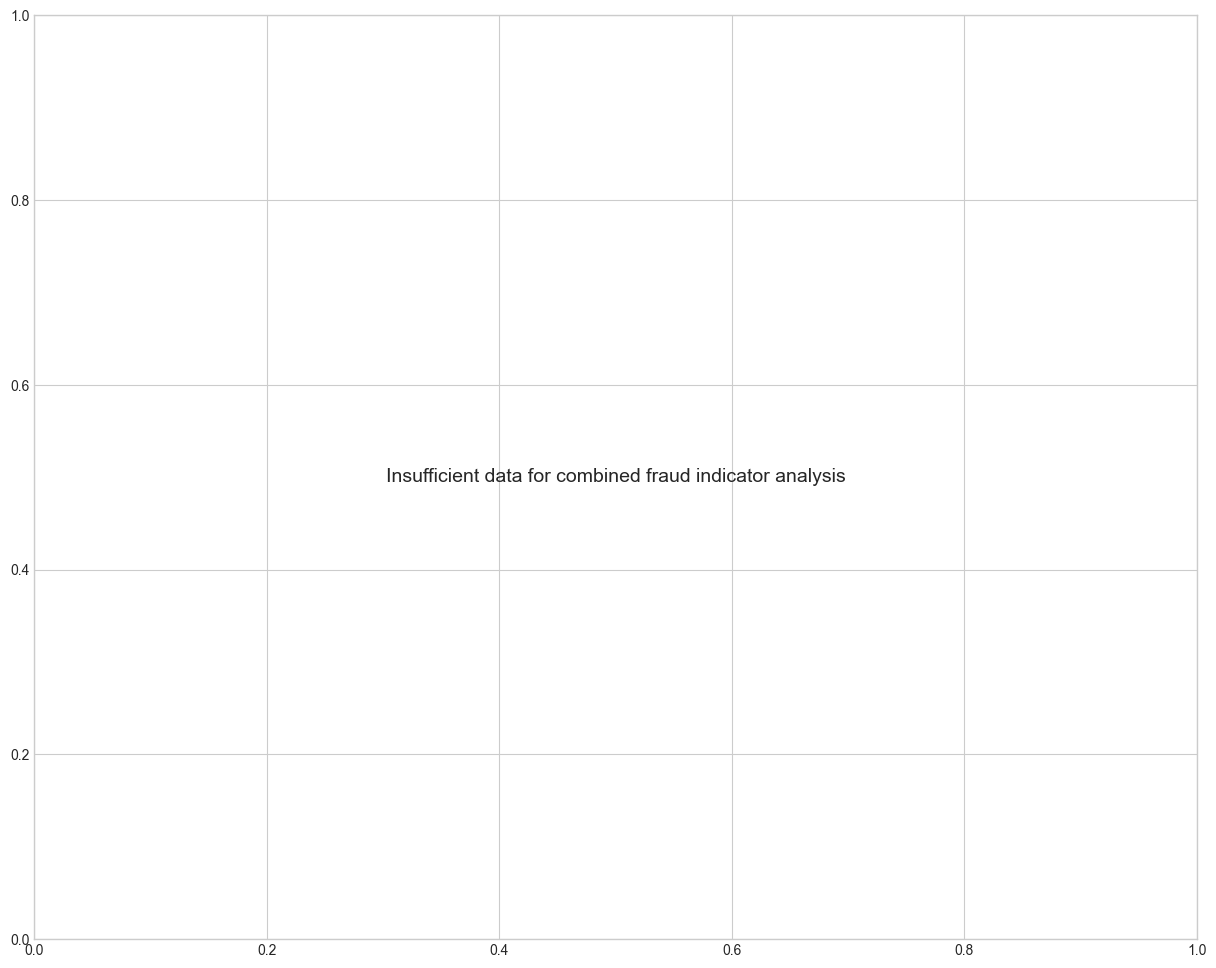

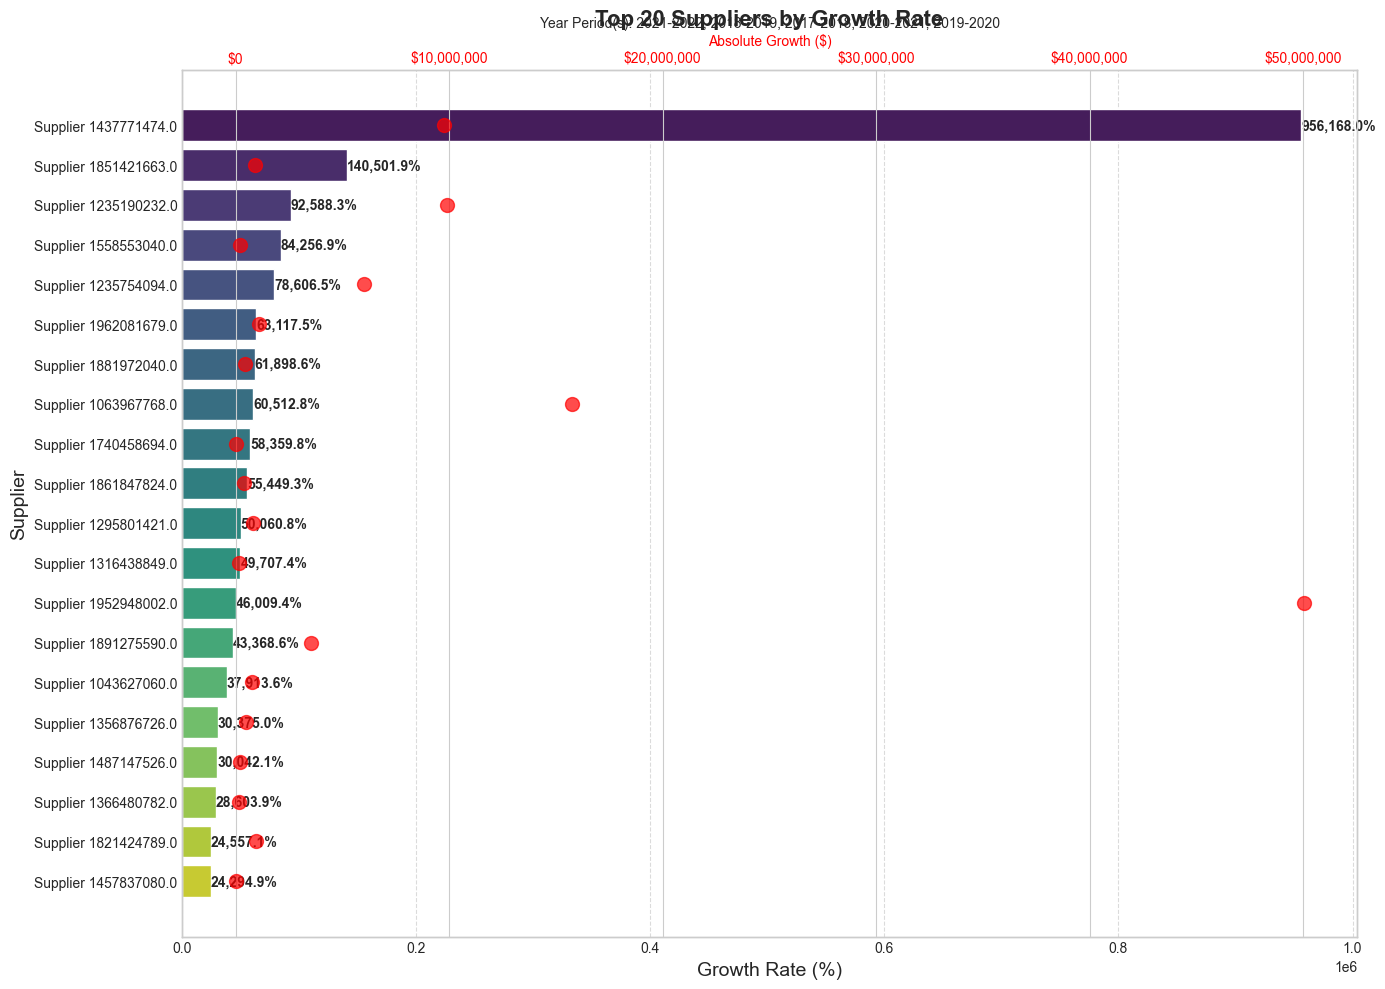

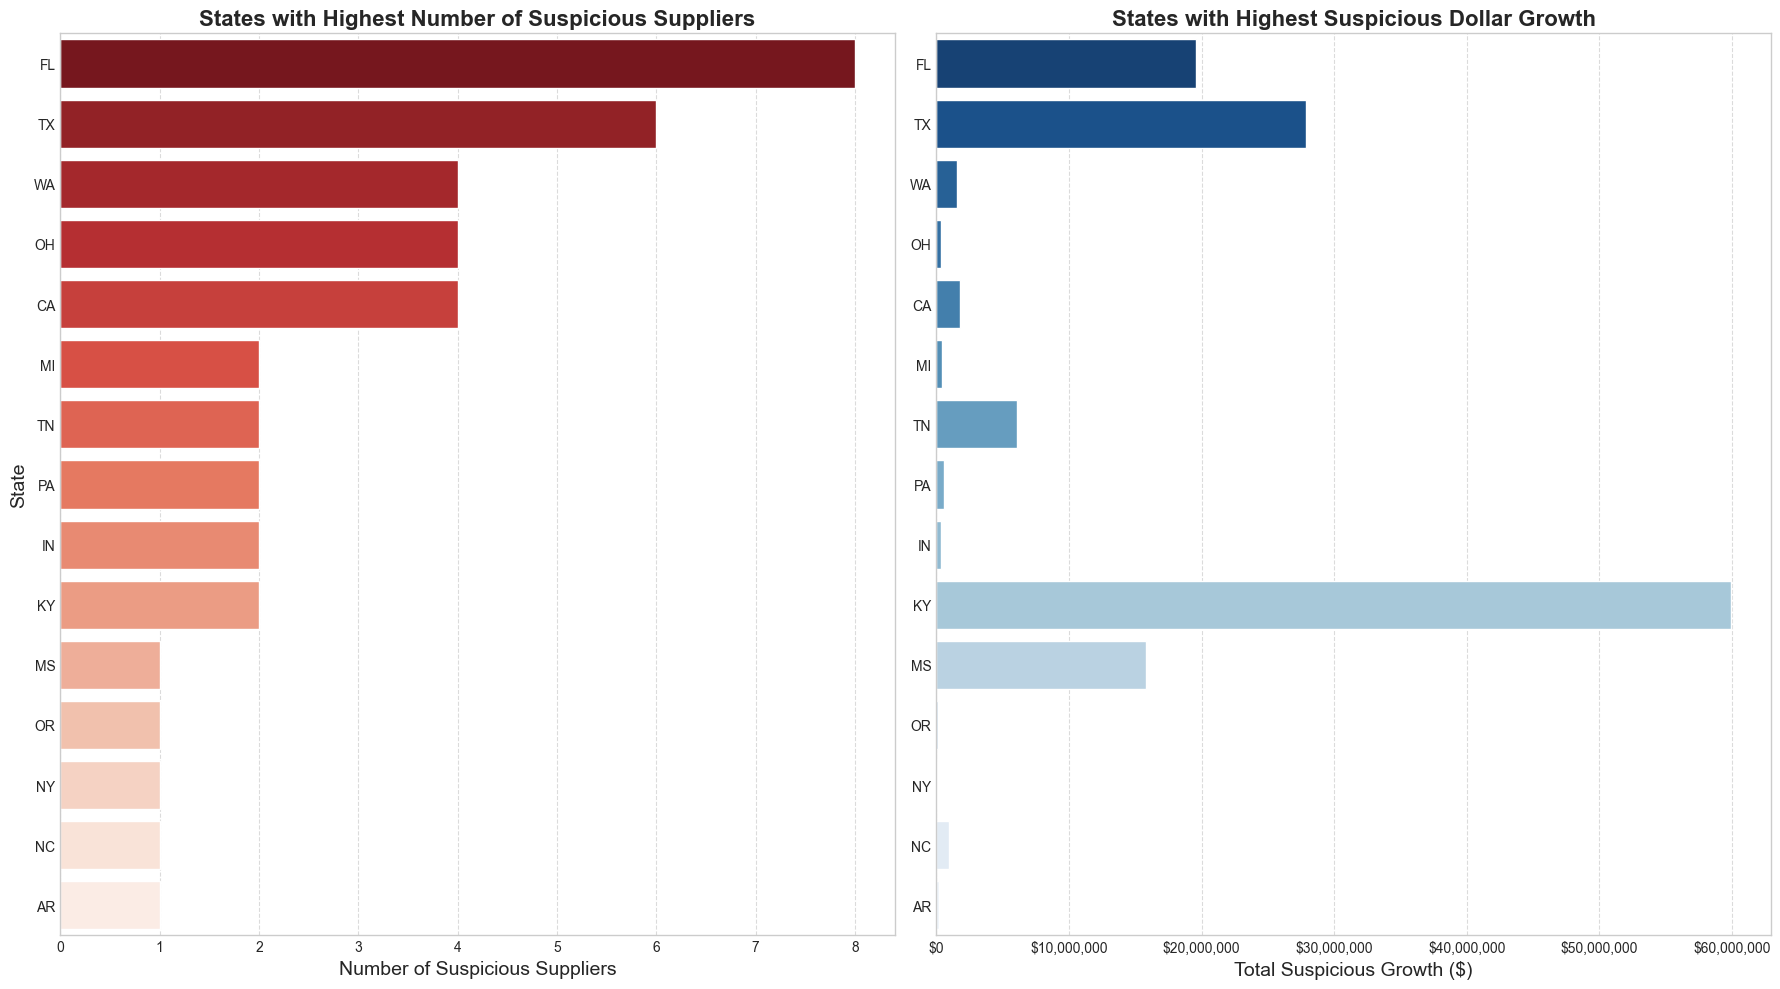

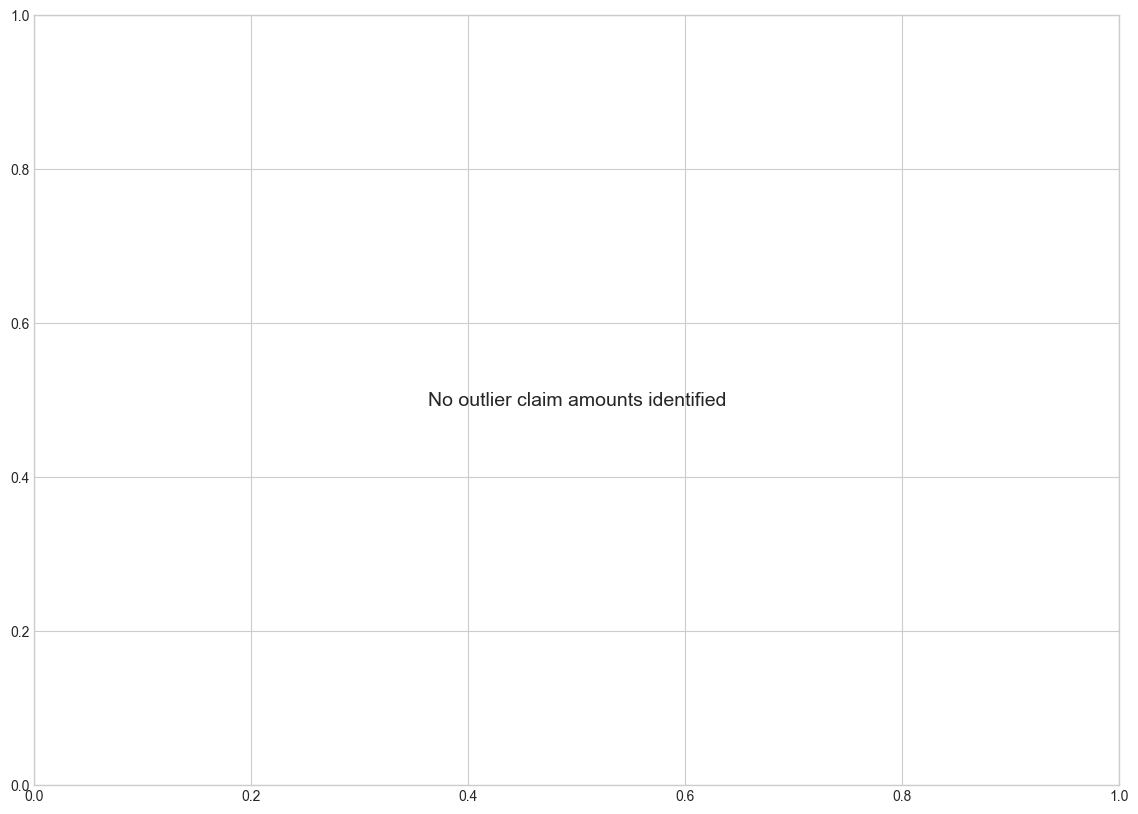

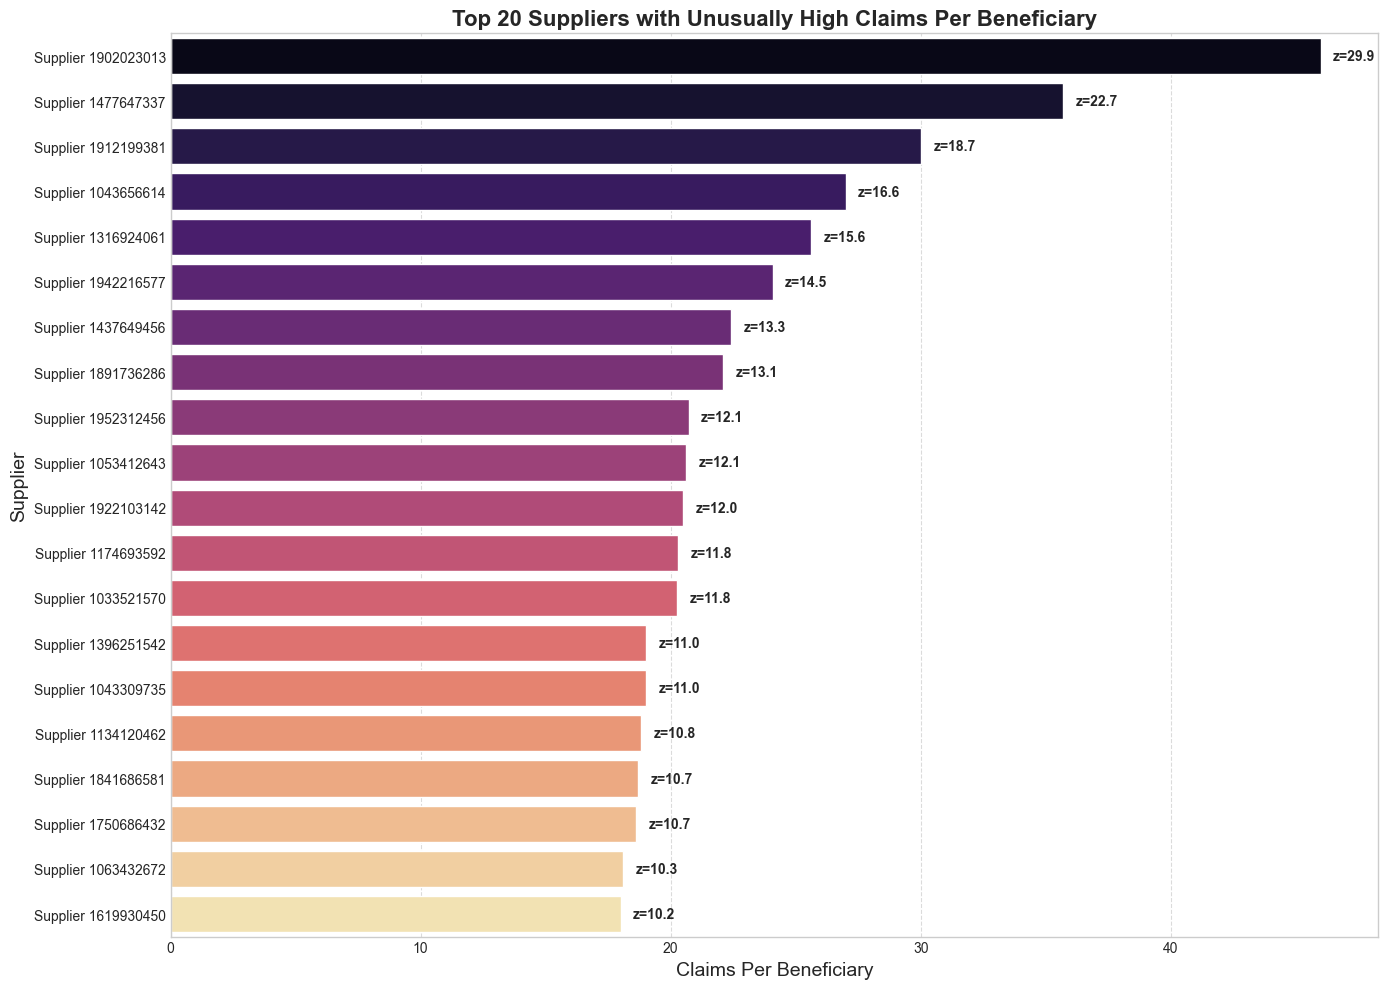

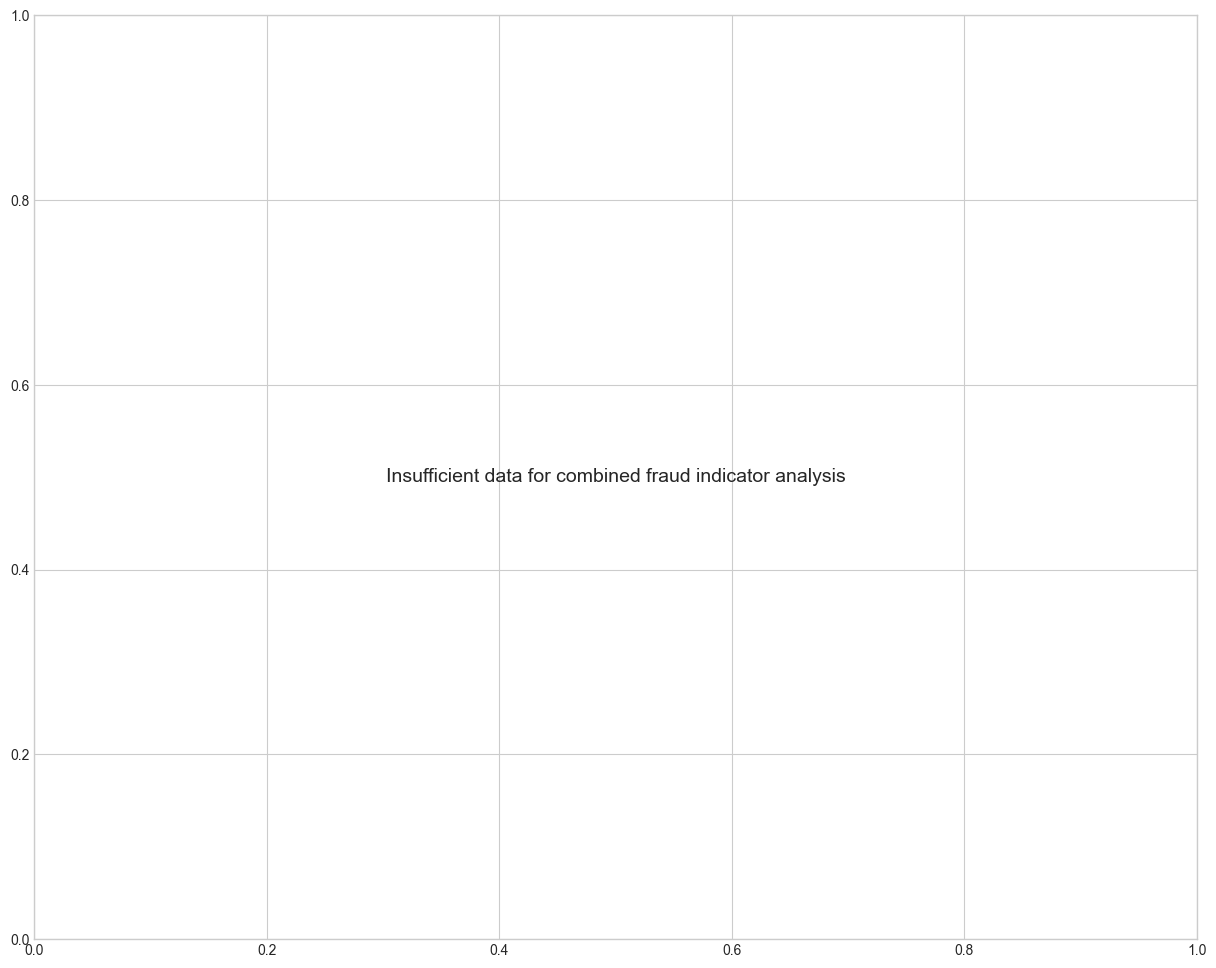

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
DME Fraud Detection Script
This script analyzes Medicare DME supplier data to identify potential fraud indicators,
with a focus on suspicious growth patterns similar to credit card fraud detection techniques.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import os
import sys

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')


def import_dme_data(file_path):
    """
    Import and preprocess DME data from a CSV file.

    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing DME data

    Returns:
    --------
    df : DataFrame
        Processed DataFrame containing DME data
    """
    print(f"Importing data from {file_path}...")

    try:
        # Import data with appropriate dtypes to handle monetary values correctly
        df = pd.read_csv(file_path, low_memory=False)

        # Convert monetary columns to numeric
        money_columns = [
            col for col in df.columns if 'Pymt' in col or 'Amt' in col]
        for col in money_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        print(f"Successfully imported data with shape: {df.shape}")
        return df

    except Exception as e:
        print(f"Error importing data: {str(e)}")
        return None


def get_column_mapping(df):
    """
    Get a mapping of expected column names to actual column names in the DataFrame.
    This helps handle variations in column names across different datasets.

    Parameters:
    -----------
    df : DataFrame
        DataFrame to inspect for column names

    Returns:
    --------
    column_map : dict
        Dictionary mapping expected column names to actual column names
    """
    column_map = {}

    # Map for supplier organization name
    if 'Suplr_Prvdr_Org_Name' in df.columns:
        column_map['supplier_name'] = 'Suplr_Prvdr_Org_Name'
    elif 'Suplr_Name' in df.columns:
        column_map['supplier_name'] = 'Suplr_Name'
    elif 'Supplier_Name' in df.columns:
        column_map['supplier_name'] = 'Supplier_Name'
    elif 'Provider_Org_Name' in df.columns:
        column_map['supplier_name'] = 'Provider_Org_Name'
    else:
        # If no suitable column exists, create a placeholder
        print("Warning: No supplier name column found. Using placeholder names.")
        column_map['supplier_name'] = None

    # Map for supplier state
    if 'Suplr_Prvdr_State_Abrvtn' in df.columns:
        column_map['supplier_state'] = 'Suplr_Prvdr_State_Abrvtn'
    elif 'Suplr_State' in df.columns:
        column_map['supplier_state'] = 'Suplr_State'
    elif 'State' in df.columns:
        column_map['supplier_state'] = 'State'
    else:
        print("Warning: No supplier state column found. Using placeholder.")
        column_map['supplier_state'] = None

    # Map for supplier NPI
    if 'Suplr_NPI' in df.columns:
        column_map['supplier_npi'] = 'Suplr_NPI'
    elif 'NPI' in df.columns:
        column_map['supplier_npi'] = 'NPI'
    elif 'Provider_NPI' in df.columns:
        column_map['supplier_npi'] = 'Provider_NPI'
    else:
        print("Warning: No NPI column found. Using index as placeholder.")
        column_map['supplier_npi'] = None

    # Print available columns if key columns are missing
    if None in column_map.values():
        print("\nAvailable columns in the dataset:")
        for i, col in enumerate(sorted(df.columns)):
            print(f"  {i+1}. {col}")
        print(
            "\nPlease adjust the script to use the correct column names for your dataset.")

    return column_map


def detect_high_growth_suppliers(df_by_year, metric='DME_Suplr_Mdcr_Pymt_Amt', top_n=50):
    """
    Identify suppliers with abnormally high growth rates year over year.

    Parameters:
    -----------
    df_by_year : dict
        Dictionary containing DataFrames by year
    metric : str
        The metric to analyze for growth (default: Medicare payments)
    top_n : int
        Number of top growth suppliers to identify

    Returns:
    --------
    growth_df : DataFrame
        DataFrame containing suppliers with their growth rates
    """
    print(f"Identifying suppliers with highest year-over-year growth rates...")

    # Check if metric exists in all dataframes
    for year, df in df_by_year.items():
        if metric not in df.columns:
            available_metrics = [
                col for col in df.columns if 'Pymt' in col or 'Amt' in col]
            if not available_metrics:
                print(
                    f"Error: No payment metrics found in data for year {year}.")
                return pd.DataFrame()

            # Use the first available payment metric
            metric = available_metrics[0]
            print(f"Using alternate metric: {metric}")
            break

    # Get all available years
    years = sorted(df_by_year.keys())

    if len(years) < 2:
        print("Error: Need at least two years of data to calculate growth rates")
        return pd.DataFrame()

    # Get column mappings from the most recent year's data
    recent_year = max(years)
    column_map = get_column_mapping(df_by_year[recent_year])

    # Create a dictionary to store supplier data across years
    supplier_data = {}
    supplier_info = {}

    # Process each supplier's data for each year
    for year in years:
        df = df_by_year[year]

        # Get NPI column name
        npi_col = column_map['supplier_npi']
        if npi_col is None:
            # Create a synthetic NPI using index
            df['synthetic_npi'] = 'NPI' + df.index.astype(str)
            npi_col = 'synthetic_npi'

        # Group by supplier NPI and sum the metric
        supplier_metric = df.groupby(npi_col)[metric].sum().reset_index()

        # Store in dictionary
        for _, row in supplier_metric.iterrows():
            npi = row[npi_col]
            value = row[metric]

            if npi not in supplier_data:
                supplier_data[npi] = {}

                # Store supplier info for later use
                supplier_row = df[df[npi_col] == npi].iloc[0] if len(
                    df[df[npi_col] == npi]) > 0 else None
                if supplier_row is not None:
                    supplier_info[npi] = {
                        'name': supplier_row[column_map['supplier_name']] if column_map['supplier_name'] is not None else f"Supplier {npi}",
                        'state': supplier_row[column_map['supplier_state']] if column_map['supplier_state'] is not None else 'Unknown'
                    }
                else:
                    supplier_info[npi] = {
                        'name': f"Supplier {npi}",
                        'state': 'Unknown'
                    }

            supplier_data[npi][year] = value

    # Calculate year-over-year growth rates
    growth_data = []

    for npi, year_values in supplier_data.items():
        # Need at least two years of data for this supplier
        if len(year_values) < 2:
            continue

        for i in range(len(years) - 1):
            current_year = years[i]
            next_year = years[i + 1]

            # Skip if supplier doesn't have data for both years
            if current_year not in year_values or next_year not in year_values:
                continue

            current_value = year_values[current_year]
            next_value = year_values[next_year]

            # Skip if current value is zero (would result in infinity growth)
            if current_value == 0:
                continue

            # Calculate growth rate
            growth_rate = ((next_value - current_value) / current_value) * 100

            growth_data.append({
                'Supplier NPI': npi,
                'Supplier Name': supplier_info[npi]['name'],
                'Supplier State': supplier_info[npi]['state'],
                'Year Period': f"{current_year}-{next_year}",
                'Start Year Value': current_value,
                'End Year Value': next_value,
                'Growth Rate (%)': growth_rate,
                'Absolute Growth': next_value - current_value
            })

    # Convert to DataFrame
    growth_df = pd.DataFrame(growth_data)

    # Sort by growth rate (descending)
    growth_df = growth_df.sort_values('Growth Rate (%)', ascending=False)

    return growth_df.head(top_n)


def detect_outlier_claim_amounts(df, year, metric='DME_Avg_Sbmtd_Chrg', threshold=2.0):
    """
    Identify suppliers with abnormally high average claim amounts.

    Parameters:
    -----------
    df : DataFrame
        DataFrame for a specific year
    year : int
        The year being analyzed
    metric : str
        The metric to analyze for outliers (default: average submitted charge)
    threshold : float
        Z-score threshold for flagging outliers (default: 2.0)

    Returns:
    --------
    outlier_df : DataFrame
        DataFrame containing suppliers with outlier claim amounts
    """
    print(
        f"Identifying suppliers with abnormally high average claim amounts in {year}...")

    # Get column mappings
    column_map = get_column_mapping(df)

    # Verify the metric exists
    if metric not in df.columns:
        available_metrics = [col for col in df.columns if 'Avg' in col and (
            'Chrg' in col or 'Amt' in col)]
        if not available_metrics:
            print(
                f"Error: No average charge metrics found in data for year {year}.")
            return pd.DataFrame()

        # Use the first available charge metric
        metric = available_metrics[0]
        print(f"Using alternate metric: {metric}")

    # Create a copy of the DataFrame to avoid modifying original
    df_copy = df.copy()

    # Calculate z-scores for the metric
    df_copy[f'{metric}_zscore'] = (
        df_copy[metric] - df_copy[metric].mean()) / df_copy[metric].std()

    # Filter for outliers
    outlier_df = df_copy[df_copy[f'{metric}_zscore'] > threshold].copy()

    # Sort by z-score (descending)
    outlier_df = outlier_df.sort_values(f'{metric}_zscore', ascending=False)

    # Get NPI column name
    npi_col = column_map['supplier_npi']
    if npi_col is None:
        # Create a synthetic NPI using index
        outlier_df['synthetic_npi'] = 'NPI' + outlier_df.index.astype(str)
        npi_col = 'synthetic_npi'

    # Get name column
    name_col = column_map['supplier_name']
    if name_col is None:
        # Create a synthetic name
        outlier_df['synthetic_name'] = outlier_df[npi_col].apply(
            lambda x: f"Supplier {x}")
        name_col = 'synthetic_name'

    # Get state column
    state_col = column_map['supplier_state']
    if state_col is None:
        # Create a synthetic state
        outlier_df['synthetic_state'] = 'Unknown'
        state_col = 'synthetic_state'

    # Get beneficiary and claims columns if they exist
    bene_col = 'DME_Tot_Suplr_Benes' if 'DME_Tot_Suplr_Benes' in df.columns else None
    claims_col = 'DME_Tot_Suplr_Clms' if 'DME_Tot_Suplr_Clms' in df.columns else None

    # Select relevant columns
    columns = [npi_col, name_col, state_col, metric, f'{metric}_zscore']
    if bene_col:
        columns.append(bene_col)
    if claims_col:
        columns.append(claims_col)

    # Rename columns to standard names
    result_df = outlier_df[columns].copy()
    result_df.columns = [
        'Suplr_NPI',
        'Suplr_Prvdr_Org_Name',
        'Suplr_Prvdr_State_Abrvtn',
        metric,
        f'{metric}_zscore'
    ] + (['DME_Tot_Suplr_Benes'] if bene_col else []) + (['DME_Tot_Suplr_Clms'] if claims_col else [])

    return result_df


def detect_unusual_beneficiary_to_claim_ratio(df, year, threshold=2.0):
    """
    Identify suppliers with abnormally high claim per beneficiary ratios.

    Parameters:
    -----------
    df : DataFrame
        DataFrame for a specific year
    year : int
        The year being analyzed
    threshold : float
        Z-score threshold for flagging outliers (default: 2.0)

    Returns:
    --------
    ratio_df : DataFrame
        DataFrame containing suppliers with unusual claim-to-beneficiary ratios
    """
    print(
        f"Identifying suppliers with unusual claims per beneficiary in {year}...")

    # Get column mappings
    column_map = get_column_mapping(df)

    # Check for beneficiary and claims columns
    bene_col = None
    claims_col = None

    # Look for beneficiary column
    for potential_col in ['DME_Tot_Suplr_Benes', 'Tot_Benes', 'Beneficiaries', 'Total_Beneficiaries']:
        if potential_col in df.columns:
            bene_col = potential_col
            break

    # Look for claims column
    for potential_col in ['DME_Tot_Suplr_Clms', 'Tot_Clms', 'Claims', 'Total_Claims']:
        if potential_col in df.columns:
            claims_col = potential_col
            break

    if bene_col is None or claims_col is None:
        print(
            f"Error: Unable to find beneficiary or claims columns in data for year {year}.")
        print("Available columns: ", ", ".join(sorted(df.columns)))
        return pd.DataFrame()

    # Create a copy of the DataFrame to avoid modifying original
    df_copy = df.copy()

    # Calculate claims per beneficiary
    df_copy['Claims_Per_Beneficiary'] = df_copy[claims_col] / df_copy[bene_col]

    # Calculate z-scores
    df_copy['Claims_Per_Beneficiary_zscore'] = (
        df_copy['Claims_Per_Beneficiary'] - df_copy['Claims_Per_Beneficiary'].mean()) / df_copy['Claims_Per_Beneficiary'].std()

    # Filter for outliers
    ratio_df = df_copy[df_copy['Claims_Per_Beneficiary_zscore']
                       > threshold].copy()

    # Sort by z-score (descending)
    ratio_df = ratio_df.sort_values(
        'Claims_Per_Beneficiary_zscore', ascending=False)

    # Get NPI column name
    npi_col = column_map['supplier_npi']
    if npi_col is None:
        # Create a synthetic NPI using index
        ratio_df['synthetic_npi'] = 'NPI' + ratio_df.index.astype(str)
        npi_col = 'synthetic_npi'

    # Get name column
    name_col = column_map['supplier_name']
    if name_col is None:
        # Create a synthetic name
        ratio_df['synthetic_name'] = ratio_df[npi_col].apply(
            lambda x: f"Supplier {x}")
        name_col = 'synthetic_name'

    # Get state column
    state_col = column_map['supplier_state']
    if state_col is None:
        # Create a synthetic state
        ratio_df['synthetic_state'] = 'Unknown'
        state_col = 'synthetic_state'

    # Select relevant columns
    columns = [
        npi_col,
        name_col,
        state_col,
        bene_col,
        claims_col,
        'Claims_Per_Beneficiary',
        'Claims_Per_Beneficiary_zscore'
    ]

    # Rename columns to standard names
    result_df = ratio_df[columns].copy()
    result_df.columns = [
        'Suplr_NPI',
        'Suplr_Prvdr_Org_Name',
        'Suplr_Prvdr_State_Abrvtn',
        'DME_Tot_Suplr_Benes',
        'DME_Tot_Suplr_Clms',
        'Claims_Per_Beneficiary',
        'Claims_Per_Beneficiary_zscore'
    ]

    return result_df


def plot_high_growth_suppliers(growth_df, top_n=20):
    """
    Create a visualization of suppliers with highest growth rates.

    Parameters:
    -----------
    growth_df : DataFrame
        DataFrame from detect_high_growth_suppliers function
    top_n : int
        Number of top suppliers to visualize

    Returns:
    --------
    fig : Figure
        Matplotlib figure object containing the visualization
    """
    # Take top N suppliers
    plot_df = growth_df.head(top_n)

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))

    # Plot horizontal bar chart
    bars = sns.barplot(
        x='Growth Rate (%)',
        y='Supplier Name',
        data=plot_df,
        palette='viridis',
        ax=ax
    )

    # Add value labels
    for i, bar in enumerate(bars.patches):
        value = plot_df.iloc[i]['Growth Rate (%)']
        ax.text(
            bar.get_width() + 10,
            bar.get_y() + bar.get_height()/2,
            f"{value:,.1f}%",
            ha='left',
            va='center',
            fontweight='bold'
        )

    # Add a second x-axis for absolute growth
    ax2 = ax.twiny()
    ax2.set_xlabel('Absolute Growth ($)', color='red')
    ax2.tick_params(axis='x', colors='red')

    # Plot absolute growth as scatter points
    for i, (_, row) in enumerate(plot_df.iterrows()):
        ax2.scatter(row['Absolute Growth'], i, color='red', s=100, alpha=0.7)

    # Format the x-axis for absolute growth with dollar amounts
    ax2.xaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, pos: f'${x:,.0f}'))

    # Set labels and title
    ax.set_xlabel('Growth Rate (%)', fontsize=14)
    ax.set_ylabel('Supplier', fontsize=14)
    ax.set_title(f'Top {top_n} Suppliers by Growth Rate',
                 fontsize=16, fontweight='bold')

    # Add year period information
    if not plot_df.empty:
        year_periods = plot_df['Year Period'].unique()
        period_str = ', '.join(year_periods)
        ax.text(
            0.5, 1.05, f"Year Period(s): {period_str}", transform=ax.transAxes, ha='center')

    # Add grid
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    return fig


def plot_geographic_fraud_hotspots(df_by_year, growth_df, threshold=200):
    """
    Create a visualization of geographical hotspots for high-growth suppliers.

    Parameters:
    -----------
    df_by_year : dict
        Dictionary containing DataFrames by year
    growth_df : DataFrame
        DataFrame from detect_high_growth_suppliers function
    threshold : float
        Growth rate threshold for inclusion in hotspots

    Returns:
    --------
    fig : Figure
        Matplotlib figure object containing the visualization
    """
    # Filter for extremely high growth rates
    high_growth_df = growth_df[growth_df['Growth Rate (%)'] > threshold].copy()

    # Group by state and count unique suppliers
    state_counts = high_growth_df.groupby('Supplier State').agg({
        'Supplier NPI': 'nunique',
        'Growth Rate (%)': 'mean',
        'Absolute Growth': 'sum'
    }).reset_index()

    state_counts.columns = ['State', 'Suspicious Suppliers',
                            'Average Growth Rate (%)', 'Total Growth ($)']

    # Sort by count (descending)
    state_counts = state_counts.sort_values(
        'Suspicious Suppliers', ascending=False)

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

    # Plot supplier counts
    sns.barplot(
        x='Suspicious Suppliers',
        y='State',
        data=state_counts.head(15),
        palette='Reds_r',
        ax=ax1
    )

    ax1.set_xlabel('Number of Suspicious Suppliers', fontsize=14)
    ax1.set_ylabel('State', fontsize=14)
    ax1.set_title('States with Highest Number of Suspicious Suppliers',
                  fontsize=16, fontweight='bold')
    ax1.grid(axis='x', linestyle='--', alpha=0.7)

    # Plot total growth by state
    sns.barplot(
        x='Total Growth ($)',
        y='State',
        data=state_counts.head(15),
        palette='Blues_r',
        ax=ax2
    )

    # Format with dollar amounts
    ax2.xaxis.set_major_formatter(
        plt.FuncFormatter(lambda x, pos: f'${x:,.0f}'))

    ax2.set_xlabel('Total Suspicious Growth ($)', fontsize=14)
    ax2.set_ylabel('', fontsize=14)  # No y-label for second plot
    ax2.set_title('States with Highest Suspicious Dollar Growth',
                  fontsize=16, fontweight='bold')
    ax2.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    return fig


def plot_outlier_claim_patterns(outlier_df, metric='DME_Avg_Sbmtd_Chrg', top_n=20):
    """
    Create a visualization of suppliers with outlier claim patterns.

    Parameters:
    -----------
    outlier_df : DataFrame
        DataFrame from detect_outlier_claim_amounts function
    metric : str
        The metric being analyzed
    top_n : int
        Number of top suppliers to visualize

    Returns:
    --------
    fig : Figure
        Matplotlib figure object containing the visualization
    """
    # Take top N suppliers
    plot_df = outlier_df.head(top_n)

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))

    # Plot horizontal bar chart
    bars = sns.barplot(
        x=metric,
        y='Suplr_Prvdr_Org_Name',
        data=plot_df,
        palette='plasma',
        ax=ax
    )

    # Add z-score labels
    for i, bar in enumerate(bars.patches):
        zscore = plot_df.iloc[i][f'{metric}_zscore']
        ax.text(
            bar.get_width() + 5,
            bar.get_y() + bar.get_height()/2,
            f"z={zscore:.1f}",
            ha='left',
            va='center',
            fontweight='bold'
        )

    # Format the x-axis with dollar amounts if it's a monetary metric
    if 'Pymt' in metric or 'Chrg' in metric or 'Amt' in metric:
        ax.xaxis.set_major_formatter(
            plt.FuncFormatter(lambda x, pos: f'${x:,.0f}'))

    # Set labels and title
    metric_name = metric.replace('_', ' ')
    ax.set_xlabel(metric_name, fontsize=14)
    ax.set_ylabel('Supplier', fontsize=14)
    ax.set_title(f'Top {top_n} Suppliers with Unusually High {metric_name}',
                 fontsize=16, fontweight='bold')

    # Add grid
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    return fig


def plot_beneficiary_claim_ratio_outliers(ratio_df, top_n=20):
    """
    Create a visualization of suppliers with unusual beneficiary-to-claim ratios.

    Parameters:
    -----------
    ratio_df : DataFrame
        DataFrame from detect_unusual_beneficiary_to_claim_ratio function
    top_n : int
        Number of top suppliers to visualize

    Returns:
    --------
    fig : Figure
        Matplotlib figure object containing the visualization
    """
    # Take top N suppliers
    plot_df = ratio_df.head(top_n)

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10))

    # Plot horizontal bar chart
    bars = sns.barplot(
        x='Claims_Per_Beneficiary',
        y='Suplr_Prvdr_Org_Name',
        data=plot_df,
        palette='magma',
        ax=ax
    )

    # Add z-score labels
    for i, bar in enumerate(bars.patches):
        zscore = plot_df.iloc[i]['Claims_Per_Beneficiary_zscore']
        ax.text(
            bar.get_width() + 0.5,
            bar.get_y() + bar.get_height()/2,
            f"z={zscore:.1f}",
            ha='left',
            va='center',
            fontweight='bold'
        )

    # Set labels and title
    ax.set_xlabel('Claims Per Beneficiary', fontsize=14)
    ax.set_ylabel('Supplier', fontsize=14)
    ax.set_title(f'Top {top_n} Suppliers with Unusually High Claims Per Beneficiary',
                 fontsize=16, fontweight='bold')

    # Add grid
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    return fig


def plot_combined_fraud_indicators(growth_df, outlier_df, ratio_df, top_n=20):
    """
    Create a visualization of suppliers that appear in multiple fraud indicator lists.

    Parameters:
    -----------
    growth_df : DataFrame
        DataFrame from detect_high_growth_suppliers function
    outlier_df : DataFrame
        DataFrame from detect_outlier_claim_amounts function
    ratio_df : DataFrame
        DataFrame from detect_unusual_beneficiary_to_claim_ratio function
    top_n : int
        Number of top suppliers to visualize

    Returns:
    --------
    fig : Figure
        Matplotlib figure object containing the visualization
    """
    print("Identifying suppliers with multiple fraud indicators...")

    # Check if any of the dataframes are empty
    if growth_df.empty or outlier_df.empty or ratio_df.empty:
        print("Warning: One or more fraud indicator dataframes are empty. Cannot perform combined analysis.")
        # Return an empty plot
        fig, ax = plt.subplots(figsize=(15, 12))
        ax.text(0.5, 0.5, "Insufficient data for combined fraud indicator analysis",
                ha='center', va='center', fontsize=14)
        return fig, pd.DataFrame()

    # Get unique supplier NPIs from each DataFrame
    growth_npis = set(growth_df['Supplier NPI'])
    outlier_npis = set(outlier_df['Suplr_NPI'])
    ratio_npis = set(ratio_df['Suplr_NPI'])

    # Find suppliers that appear in multiple lists
    suspicious_suppliers = []

    # Check all 3 indicators
    all_three = growth_npis & outlier_npis & ratio_npis
    for npi in all_three:
        try:
            growth_row = growth_df[growth_df['Supplier NPI'] == npi].iloc[0]
            outlier_row = outlier_df[outlier_df['Suplr_NPI'] == npi].iloc[0]
            ratio_row = ratio_df[ratio_df['Suplr_NPI'] == npi].iloc[0]

            suspicious_suppliers.append({
                'NPI': npi,
                'Supplier Name': growth_row['Supplier Name'],
                'State': growth_row['Supplier State'],
                'Growth Rate (%)': growth_row['Growth Rate (%)'],
                'Claims Per Beneficiary': ratio_row['Claims_Per_Beneficiary'],
                # Use index to get the charge column
                'Avg Charge': outlier_row[outlier_row.columns[3]],
                'Indicators': 3,
                'Flags': 'High Growth, High Charges, High Claims/Beneficiary'
            })
        except (IndexError, KeyError) as e:
            print(
                f"Error processing supplier {npi} with all three indicators: {str(e)}")
            continue

    # Check growth + outlier
    growth_outlier = (growth_npis & outlier_npis) - all_three
    for npi in growth_outlier:
        try:
            growth_row = growth_df[growth_df['Supplier NPI'] == npi].iloc[0]
            outlier_row = outlier_df[outlier_df['Suplr_NPI'] == npi].iloc[0]

            suspicious_suppliers.append({
                'NPI': npi,
                'Supplier Name': growth_row['Supplier Name'],
                'State': growth_row['Supplier State'],
                'Growth Rate (%)': growth_row['Growth Rate (%)'],
                'Claims Per Beneficiary': 0,
                # Use index to get the charge column
                'Avg Charge': outlier_row[outlier_row.columns[3]],
                'Indicators': 2,
                'Flags': 'High Growth, High Charges'
            })
        except (IndexError, KeyError) as e:
            print(
                f"Error processing supplier {npi} with growth+outlier indicators: {str(e)}")
            continue

    # Check growth + ratio
    growth_ratio = (growth_npis & ratio_npis) - all_three
    for npi in growth_ratio:
        try:
            growth_row = growth_df[growth_df['Supplier NPI'] == npi].iloc[0]
            ratio_row = ratio_df[ratio_df['Suplr_NPI'] == npi].iloc[0]

            suspicious_suppliers.append({
                'NPI': npi,
                'Supplier Name': growth_row['Supplier Name'],
                'State': growth_row['Supplier State'],
                'Growth Rate (%)': growth_row['Growth Rate (%)'],
                'Claims Per Beneficiary': ratio_row['Claims_Per_Beneficiary'],
                'Avg Charge': 0,
                'Indicators': 2,
                'Flags': 'High Growth, High Claims/Beneficiary'
            })
        except (IndexError, KeyError) as e:
            print(
                f"Error processing supplier {npi} with growth+ratio indicators: {str(e)}")
            continue

    # Check outlier + ratio
    outlier_ratio = (outlier_npis & ratio_npis) - all_three
    for npi in outlier_ratio:
        try:
            outlier_row = outlier_df[outlier_df['Suplr_NPI'] == npi].iloc[0]
            ratio_row = ratio_df[ratio_df['Suplr_NPI'] == npi].iloc[0]

            suspicious_suppliers.append({
                'NPI': npi,
                'Supplier Name': outlier_row['Suplr_Prvdr_Org_Name'],
                'State': outlier_row['Suplr_Prvdr_State_Abrvtn'],
                'Growth Rate (%)': 0,
                'Claims Per Beneficiary': ratio_row['Claims_Per_Beneficiary'],
                # Use index to get the charge column
                'Avg Charge': outlier_row[outlier_row.columns[3]],
                'Indicators': 2,
                'Flags': 'High Charges, High Claims/Beneficiary'
            })
        except (IndexError, KeyError) as e:
            print(
                f"Error processing supplier {npi} with outlier+ratio indicators: {str(e)}")
            continue

    # Convert to DataFrame
    combined_df = pd.DataFrame(suspicious_suppliers)

    # If no suppliers found with multiple indicators, return empty
    if combined_df.empty:
        print("No suppliers found with multiple fraud indicators.")
        fig, ax = plt.subplots(figsize=(15, 12))
        ax.text(0.5, 0.5, "No suppliers identified with multiple fraud indicators",
                ha='center', va='center', fontsize=14)
        return fig, combined_df

    # Sort by number of indicators (descending), then by growth rate
    combined_df = combined_df.sort_values(
        ['Indicators', 'Growth Rate (%)'], ascending=[False, False])

    # Take top N suppliers
    plot_df = combined_df.head(top_n)

    # Create figure
    fig, ax = plt.subplots(figsize=(15, 12))

    # Plot horizontal bar chart, colored by number of indicators
    scatter = ax.scatter(
        plot_df['Growth Rate (%)'],
        range(len(plot_df)),
        c=plot_df['Indicators'],
        cmap='RdYlBu_r',
        s=300,
        alpha=0.7
    )

    # Set y-tick labels to supplier names
    ax.set_yticks(range(len(plot_df)))
    ax.set_yticklabels(plot_df['Supplier Name'])

    # Create a colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Number of Fraud Indicators', rotation=270, labelpad=20)

    # Add text labels with flag information
    for i, (_, row) in enumerate(plot_df.iterrows()):
        ax.text(
            row['Growth Rate (%)'] + 5,
            i,
            row['Flags'],
            va='center',
            fontsize=9
        )

    # Set labels and title
    ax.set_xlabel('Growth Rate (%)', fontsize=14)
    ax.set_ylabel('Supplier', fontsize=14)
    ax.set_title('Suppliers with Multiple Fraud Indicators',
                 fontsize=16, fontweight='bold')

    # Add grid
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    return fig, combined_df


def create_fraud_detection_visualizations(df_by_year):
    """
    Create all fraud detection visualizations for a Jupyter notebook.

    Parameters:
    -----------
    df_by_year : dict
        Dictionary with yearly dataframes

    Returns:
    --------
    visualizations : dict
        Dictionary with all visualizations
    data : dict
        Dictionary with all data DataFrames
    """
    # Initialize results dictionaries
    visualizations = {}
    data = {}

    if not df_by_year:
        print("Error: No data provided. Cannot create visualizations.")
        return {}, {}

    # Most recent year
    recent_year = max(df_by_year.keys())

    # Display column names for debugging
    print("\nColumn names available in the most recent year's data:")
    for i, col in enumerate(sorted(df_by_year[recent_year].columns)):
        print(f"  {i+1}. {col}")

    # 1. Detect high growth suppliers
    print("\nDetecting high growth suppliers...")
    growth_df = detect_high_growth_suppliers(df_by_year, top_n=50)
    data['high_growth_suppliers'] = growth_df

    if not growth_df.empty:
        # Create high growth visualization
        growth_fig = plot_high_growth_suppliers(growth_df, top_n=20)
        visualizations['high_growth_suppliers'] = growth_fig
        print("✓ High growth suppliers visualization created successfully.")
    else:
        # Create empty plot
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.text(0.5, 0.5, "No high growth suppliers identified",
                ha='center', va='center', fontsize=14)
        visualizations['high_growth_suppliers'] = fig
        print("⚠ No high growth suppliers identified.")

    # 2. Detect geographic fraud hotspots
    print("\nDetecting geographic fraud hotspots...")
    if not growth_df.empty:
        hotspots_fig = plot_geographic_fraud_hotspots(df_by_year, growth_df)
        visualizations['geographic_hotspots'] = hotspots_fig
        print("✓ Geographic hotspots visualization created successfully.")
    else:
        # Create empty plot
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.text(0.5, 0.5, "No geographic hotspots identified (no high growth suppliers)",
                ha='center', va='center', fontsize=14)
        visualizations['geographic_hotspots'] = fig
        print("⚠ No geographic hotspots identified (no high growth suppliers).")

    # 3. Detect outlier claim amounts
    print("\nDetecting outlier claim amounts...")
    outlier_df = detect_outlier_claim_amounts(
        df_by_year[recent_year], recent_year)
    data['outlier_claims'] = outlier_df

    if not outlier_df.empty:
        outlier_fig = plot_outlier_claim_patterns(outlier_df)
        visualizations['outlier_claims'] = outlier_fig
        print("✓ Outlier claim patterns visualization created successfully.")
    else:
        # Create empty plot
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.text(0.5, 0.5, "No outlier claim amounts identified",
                ha='center', va='center', fontsize=14)
        visualizations['outlier_claims'] = fig
        print("⚠ No outlier claim amounts identified.")

    # 4. Detect unusual beneficiary-to-claim ratios
    print("\nDetecting unusual beneficiary-to-claim ratios...")
    ratio_df = detect_unusual_beneficiary_to_claim_ratio(
        df_by_year[recent_year], recent_year)
    data['unusual_ratios'] = ratio_df

    if not ratio_df.empty:
        ratio_fig = plot_beneficiary_claim_ratio_outliers(ratio_df)
        visualizations['unusual_ratios'] = ratio_fig
        print("✓ Unusual beneficiary-to-claim ratios visualization created successfully.")
    else:
        # Create empty plot
        fig, ax = plt.subplots(figsize=(14, 10))
        ax.text(0.5, 0.5, "No unusual beneficiary-to-claim ratios identified",
                ha='center', va='center', fontsize=14)
        visualizations['unusual_ratios'] = fig
        print("⚠ No unusual beneficiary-to-claim ratios identified.")

    # 5. Combined fraud indicators
    print("\nIdentifying suppliers with multiple fraud indicators...")
    combined_fig, combined_df = plot_combined_fraud_indicators(
        growth_df, outlier_df, ratio_df)
    visualizations['combined_indicators'] = combined_fig
    data['combined_indicators'] = combined_df

    if not combined_df.empty:
        print("✓ Combined fraud indicators visualization created successfully.")
    else:
        print("⚠ No suppliers with multiple fraud indicators identified.")

    return visualizations, data


def main():
    """Main function to import and analyze DME data for fraud detection."""
    print("DME Fraud Detection Analysis")
    print("===========================\n")

    # Dictionary to store dataframes by year
    df_by_year = {}

    # Import data for years 2017-2022
    for year in range(2017, 2023):
        csv_path = f"data/{year}/mup_dme_ry24_p05_v10_dy{str(year)[-2:]}_supr.csv"
        if os.path.exists(csv_path):
            print(f"Importing data for {year}...")
            try:
                df = pd.read_csv(csv_path, low_memory=False)

                # Convert monetary columns to numeric
                money_columns = [
                    col for col in df.columns if 'Pymt' in col or 'Amt' in col]
                for col in money_columns:
                    if col in df.columns:
                        df[col] = pd.to_numeric(df[col], errors='coerce')

                df_by_year[year] = df
                print(
                    f"✓ Data for {year} imported successfully. Shape: {df.shape}")
            except Exception as e:
                print(f"Error importing data for {year}: {str(e)}")
        else:
            print(f"Warning: No data file found for {year}")

    if not df_by_year:
        print("\nError: No data files were successfully imported. Cannot proceed with analysis.")
        return {}, {}, {}

    print(f"\n{len(df_by_year)} year(s) of data imported.")

    # Print column names from the first year to help diagnose column issues
    first_year = min(df_by_year.keys())
    print(f"\nSample column names from {first_year} data:")
    # Show first 20 columns
    for i, col in enumerate(sorted(df_by_year[first_year].columns)[:20]):
        print(f"  {i+1}. {col}")

    if len(df_by_year[first_year].columns) > 20:
        print(
            f"  ... and {len(df_by_year[first_year].columns) - 20} more columns")

    # ----- FRAUD DETECTION ANALYSIS -----
    print("\n1. High Growth Rate Analysis")
    print("--------------------------\n")

    # Detect suppliers with abnormally high growth rates
    growth_df = detect_high_growth_suppliers(df_by_year, top_n=50)

    if growth_df.empty:
        print("No suppliers with high growth rates detected. Cannot proceed with this part of the analysis.")
    else:
        # Print summary of top 15 high-growth suppliers
        print("Top 15 suppliers with highest growth rates:")

        # Format the output for display
        formatted_growth_df = growth_df.head(15).copy()
        formatted_growth_df['Growth Rate (%)'] = formatted_growth_df['Growth Rate (%)'].apply(
            lambda x: f"{x:.2f}%")
        formatted_growth_df['Start Year Value'] = formatted_growth_df['Start Year Value'].apply(
            lambda x: f"${x:,.2f}")
        formatted_growth_df['End Year Value'] = formatted_growth_df['End Year Value'].apply(
            lambda x: f"${x:,.2f}")
        formatted_growth_df['Absolute Growth'] = formatted_growth_df['Absolute Growth'].apply(
            lambda x: f"${x:,.2f}")

        print(formatted_growth_df.to_string(index=False))

        # ----- GEOGRAPHIC ANALYSIS -----
        print("\n2. Geographic Fraud Hotspots")
        print("-------------------------\n")

        # Group high growth suppliers by state
        high_growth_states = growth_df.groupby('Supplier State').agg({
            'Supplier NPI': 'nunique',
            'Growth Rate (%)': 'mean',
            'Absolute Growth': 'sum'
        }).reset_index()

        high_growth_states.columns = [
            'State', 'Suspicious Suppliers', 'Average Growth Rate (%)', 'Total Growth ($)']
        high_growth_states = high_growth_states.sort_values(
            'Suspicious Suppliers', ascending=False)

        print("States with highest number of suspicious suppliers:")

        # Format for display
        formatted_states = high_growth_states.head(10).copy()
        formatted_states['Average Growth Rate (%)'] = formatted_states['Average Growth Rate (%)'].apply(
            lambda x: f"{x:.2f}%")
        formatted_states['Total Growth ($)'] = formatted_states['Total Growth ($)'].apply(
            lambda x: f"${x:,.2f}")

        print(formatted_states.to_string(index=False))

    # ----- OUTLIER CLAIM ANALYSIS -----
    print("\n3. Outlier Claim Amount Analysis")
    print("-----------------------------\n")

    # Most recent year
    recent_year = max(df_by_year.keys())

    # Detect suppliers with outlier claim amounts
    outlier_df = detect_outlier_claim_amounts(
        df_by_year[recent_year], recent_year)

    if outlier_df.empty:
        print(
            f"No suppliers with outlier claim amounts detected in {recent_year}.")
    else:
        print(f"Top 10 suppliers with outlier claim amounts in {recent_year}:")

        # Format for display
        try:
            formatted_outliers = outlier_df.head(10).copy()

            # Use the metric column name (4th column)
            metric_col = outlier_df.columns[3]
            zscore_col = outlier_df.columns[4]

            # Format monetary values with dollar signs
            if 'Pymt' in metric_col or 'Chrg' in metric_col or 'Amt' in metric_col:
                formatted_outliers[metric_col] = formatted_outliers[metric_col].apply(
                    lambda x: f"${x:,.2f}")

            formatted_outliers[zscore_col] = formatted_outliers[zscore_col].apply(
                lambda x: f"{x:.2f}")

            print(formatted_outliers.to_string(index=False))
        except Exception as e:
            print(f"Error formatting outlier data: {str(e)}")
            print("Raw data:")
            print(outlier_df.head(10))

    # ----- BENEFICIARY-CLAIM RATIO ANALYSIS -----
    print("\n4. Unusual Beneficiary-to-Claim Ratio Analysis")
    print("-----------------------------------------\n")

    # Detect suppliers with unusual beneficiary-to-claim ratios
    ratio_df = detect_unusual_beneficiary_to_claim_ratio(
        df_by_year[recent_year], recent_year)

    if ratio_df.empty:
        print(
            f"No suppliers with unusual claims per beneficiary detected in {recent_year}.")
    else:
        print(
            f"Top 10 suppliers with unusual claims per beneficiary in {recent_year}:")

        # Format for display
        try:
            formatted_ratios = ratio_df.head(10).copy()
            formatted_ratios['Claims_Per_Beneficiary'] = formatted_ratios['Claims_Per_Beneficiary'].apply(
                lambda x: f"{x:.2f}")
            formatted_ratios['Claims_Per_Beneficiary_zscore'] = formatted_ratios['Claims_Per_Beneficiary_zscore'].apply(
                lambda x: f"{x:.2f}")

            print(formatted_ratios.to_string(index=False))
        except Exception as e:
            print(f"Error formatting ratio data: {str(e)}")
            print("Raw data:")
            print(ratio_df.head(10))

    # ----- COMBINED FRAUD INDICATORS -----
    print("\n5. Combined Fraud Indicators")
    print("-------------------------\n")

    # Identify suppliers that appear in multiple fraud indicator lists
    combined_fig, combined_df = plot_combined_fraud_indicators(
        growth_df, outlier_df, ratio_df)

    if combined_df.empty:
        print("No suppliers with multiple fraud indicators identified.")
    else:
        print("Top 10 suppliers with multiple fraud indicators:")

        # Format for display
        try:
            formatted_combined = combined_df.head(10).copy()
            formatted_combined['Growth Rate (%)'] = formatted_combined['Growth Rate (%)'].apply(
                lambda x: f"{x:.2f}%" if x > 0 else "N/A")
            formatted_combined['Claims Per Beneficiary'] = formatted_combined['Claims Per Beneficiary'].apply(
                lambda x: f"{x:.2f}" if x > 0 else "N/A")
            formatted_combined['Avg Charge'] = formatted_combined['Avg Charge'].apply(
                lambda x: f"${x:,.2f}" if x > 0 else "N/A")

            print(formatted_combined.to_string(index=False))
        except Exception as e:
            print(f"Error formatting combined data: {str(e)}")
            print("Raw data:")
            print(combined_df.head(10))

    # ----- VISUALIZATIONS -----
    print("\n\n6. Generating Fraud Detection Visualizations")
    print("------------------------------------------\n")

    # Setting plot style
    sns.set_style('whitegrid')
    plt.rcParams['figure.figsize'] = [14, 9]

    # Generate all visualizations
    visualizations, data = create_fraud_detection_visualizations(df_by_year)

    # Save visualizations to files if not in a notebook environment
    try:
        # Check if we're in a notebook environment
        if 'ipykernel' not in sys.modules:
            print("\nSaving visualizations to files...")
            os.makedirs('fraud_visualizations', exist_ok=True)
            for name, fig in visualizations.items():
                fig.savefig(
                    f'fraud_visualizations/{name}.png', dpi=300, bbox_inches='tight')
                print(f"Saved: fraud_visualizations/{name}.png")
    except Exception as e:
        print(f"Error saving visualizations: {str(e)}")
        print("Note: Visualizations will be displayed if run in a Jupyter notebook")

    # When run in Jupyter, the figures will be displayed inline
    return df_by_year, visualizations, data


if __name__ == "__main__":
    main()
